In [154]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Multilayer perceptron + Backpropagation

Set a seed for reproducibility:

In [155]:
SEED = 42

In [156]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(SEED)

## Training using backpropagation

Train set size: 800
Test set size: 200
X_train_min: -2.7006378421518584, X_train_max: 3.056834530918784
ymin: 0, ymax: 2


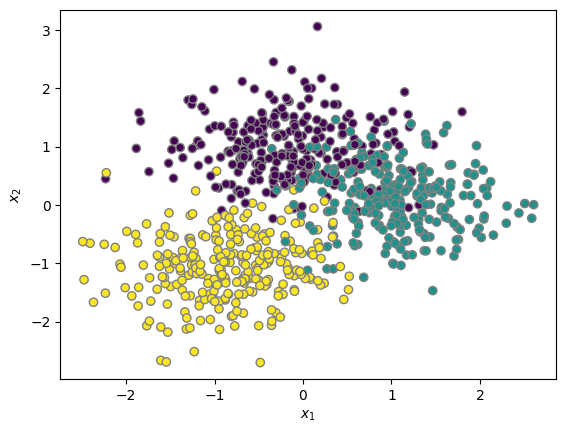

In [157]:
from utils import make_classification_dataset, standard_scaler
from sklearn.model_selection import train_test_split

num_classes = 3  # number
X, y = make_classification_dataset(1000, 2, num_classes, cluster_std=4)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Standardize X
X_train, mean, std = standard_scaler(X_train)
X_test, _, _ = standard_scaler(X_test, mean, std)

print(f"Train set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

# Plot the dataset
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolors="gray")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

print(f"X_train_min: {X_train.min()}, X_train_max: {X_train.max()}")

print(f"ymin: {y.min()}, ymax: {y.max()}")

In [158]:
def softmax(z):
    """ Softmax function.
    
    Args:
        z: the input of the softmax function.
    
    Returns:
        the output of the softmax function.
    """
    return np.exp(z) / np.sum(np.exp(z))

def sigmoid(z):
    """ Sigmoid function.
    
    Args:
        z: the input of the sigmoid function.
    
    Returns:
        the output of the sigmoid function.
    """
    return 1 / (1 + np.exp(-z))


def cross_entropy_loss(y_pred, class_idx):
    """ Compute the cross-entropy loss for a single exemplar.
    
    Args:
        y_pred: the predicted class probabilities.
        class_idx: the index of the true class.
    """
    loss = -np.log(y_pred[class_idx, 0])
    return loss

def cross_entropy_grad(y_pred, class_idx):
    """ Compute the gradient of the cross-entropy loss wrt the predicted class probabilities.

    Args:
        y_pred: the predicted class probabilities.
        class_idx: the index of the true class.
    """
    grad = -1 / y_pred[class_idx, 0]
    grad_output = np.zeros_like(y_pred)
    grad_output[class_idx] = grad
    return grad_output

def softmax_grad(grad_output, y_pred):
    """ Computer the gradient of the loss wrt the logits of the softmax function. 
    
    Args:
        grad_output: the gradient of the loss wrt the output of the softmax.
        y_pred: the output of the softmax function.
    """

    # Compute the Jacobian matrix of the softmax function
    J = np.dot(-y_pred, y_pred.T)
    J[np.diag_indices_from(J)] = y_pred.flatten() * (1 - y_pred.flatten())
    grad = np.dot(J.T, grad_output)
    return grad


def sigmoid_grad(grad_output, s):
    """ Compute the gradient of the loss wrt the output of the sigmoid function.

    Args:
        grad_output: the gradient of the loss wrt the output of the sigmoid function.
        s: the output of the sigmoid function.
    """
    grad = grad_output * s * (1 - s)
    return grad

def linear_gradW(grad_output, x):
    """ Compute the gradient of the loss wrt the output of a linear layer.

    Args:
        grad_output: the gradient of the loss wrt the output of the linear layer.
        x: the input of the linear layer.
    """
    grad = np.dot(x, grad_output.T)
    return grad

def linear_gradx(grad_output, W):
    """ Compute the gradient of the loss wrt the input of a linear layer.

    Args:
        grad_output: the gradient of the loss wrt the output of the linear layer.
        W: the weights of the linear layer.
    """
    grad = np.dot(W, grad_output)
    return grad

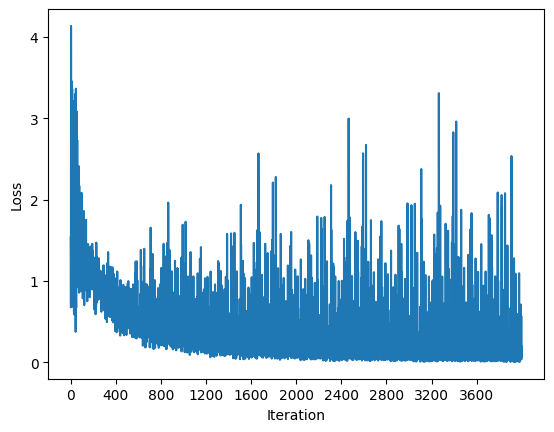

In [159]:
from utils import plot_loss_history

np.random.seed(SEED)

num_epochs = 5
learning_rate = 1e-02

# Add a bias term
X_b = np.hstack([X_train, np.ones((X_train.shape[0], 1))])

# Random weights initialization
num_hidden_units = 10 # number of hidden units
W1 = np.random.normal(size=(X_b.shape[1], num_hidden_units))  # 2 features + 1 bias, 10 hidden units
W2 = np.random.normal(size=(num_hidden_units + 1, num_classes))  # 10 hidden units + 1 bias, 3 classes
h1 = np.ones((num_hidden_units + 1, 1))  # 10 hidden units + 1 bias

iteration = 0
loss_history = []
for epoch in range(num_epochs):
    for k in range(len(X_b)):
        x = X_b[k].reshape(-1, 1)  # make it a column vector

        # Forward pass (prediction)
        z1 = np.dot(W1.T, x) # 10 hidden units
        h1[:-1] = sigmoid(z1) # 10 hidden units
        z2 = np.dot(W2.T, h1)  # 3 classes
        y_pred = softmax(z2) # 3 classes

        # Loss
        loss_value = cross_entropy_loss(y_pred, y_train[k])
        loss_history.append(loss_value)

        # Backward pass (gradient computation)
        grad_loss = cross_entropy_grad(y_pred, y_train[k])
        grad_z2 = softmax_grad(grad_loss, y_pred)
        grad_W2 = linear_gradW(grad_z2, h1)
        grad_h1 = linear_gradx(grad_z2, W2)
        grad_z1 = sigmoid_grad(grad_h1[:-1], h1[:-1])
        grad_W1 = linear_gradW(grad_z1, x)

        # Update weights
        W1 = W1 - learning_rate * grad_W1
        W2 = W2 - learning_rate * grad_W2

        iteration += 1

plot_loss_history(loss_history, interval=iteration // 10)

### Test

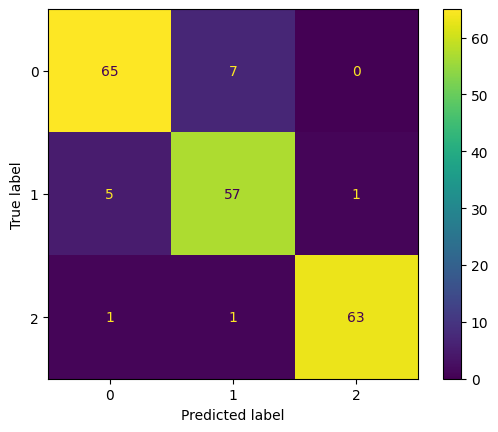


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91        72
           1       0.88      0.90      0.89        63
           2       0.98      0.97      0.98        65

    accuracy                           0.93       200
   macro avg       0.93      0.93      0.93       200
weighted avg       0.93      0.93      0.93       200



In [160]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

X_b = np.hstack([X_test, np.ones((X_test.shape[0], 1))])

y_pred = []
for k in range(len(X_b)):
    x = X_b[k].reshape(-1, 1)  # make it a column vector
    # Forward pass (prediction)
    z1 = np.dot(W1.T, x) # 10 hidden units
    h1[:-1] = sigmoid(z1) # 10 hidden units
    z2 = np.dot(W2.T, h1) # 3 classes
    y_pred.append(np.argmax(z2))
y_pred = np.array(y_pred)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Compute classification report
class_report = classification_report(y_test, y_pred)

print("\nClassification Report:")
print(class_report)

### A batch gradient descent approach

In [161]:
def softmax(z):
    """Softmax function (batch version).

    Args:
        z: the input of the softmax function.

    Returns:
        the output of the softmax function (probabilities).
    """
    return np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True)


def cross_entropy_loss(Y_pred, class_idxs):
    """Compute the cross-entropy loss for a batch of exemplars.

    Args:
        Y_pred: the predicted class probabilities.
        class_idxs: the indices of the true classes.

    Returns:
        the cross-entropy loss.
    """
    losses = -np.log(Y_pred[range(len(class_idxs)), class_idxs])
    return np.mean(losses)


def cross_entropy_grad(Y_pred, class_idxs):
    """Compute the gradient of the cross-entropy loss wrt the predicted class probabilities (batch version).

    Args:
        Y_pred: the predicted class probabilities.
        class_idxs: the indices of the true classes.

    Returns:
        the gradient of the loss wrt the predicted class probabilities.
    """
    grad = -1 / Y_pred[range(len(Y_pred)), class_idxs] # n,
    grad_output = np.zeros_like(Y_pred) # (n, k)
    grad_output[range(len(grad_output)), class_idxs] = grad # (n, k)
    return grad_output # (n, k)


def softmax_grad(grad_output, Y_pred):
    """Computer the gradient of the loss wrt the logits of the softmax function (batch version).

    Args:
        grad_output: the gradient of the loss wrt the output of the softmax.
        Y_pred: the output of the softmax function.

    Returns:
        the gradient of the loss wrt the logits of the softmax function.
    """
    grad = np.zeros_like(grad_output) # (n, k)
    for i in range(len(grad_output)):
        y_pred = Y_pred[i].reshape(-1, 1) # (k, 1)
        J = np.dot(-y_pred, y_pred.T) # (k, 1) * (1, k) => (k, k)
        J[np.diag_indices_from(J)] = y_pred.flatten() * (1 - y_pred.flatten()) # (k, k)
        grad[i] = np.dot(grad_output[i], J) # (k,) @ (k, k) => (k,)
    return grad


def sigmoid_grad(grad_output, s):
    """Compute the gradient of the loss wrt the output of the sigmoid function (batch version).

    Args:
        grad_output: the gradient of the loss wrt the output of the sigmoid function.
        s: the output of the sigmoid function.

    Returns:
        the gradient of the loss wrt the output of the sigmoid function.
    """
    grad = grad_output * s * (1 - s) # (n, h) * (n, h) => (n, h)
    return grad

def linear_gradW(grad_output, X):
    """Compute the gradient of the loss wrt the output of a linear layer (batch version).

    Args:
        grad_output: the gradient of the loss wrt the output of the linear layer.
        X: the input of the linear layer.
    
    Returns:
        the gradient of the loss wrt the weights of the linear layer.
    """
    grad = np.dot(X.T, grad_output) # (d, n) @ (n, h) => (d, h)
    
    # average over the batch
    grad /= X.shape[0]
    return grad

def linear_gradX(grad_output, W):
    """Compute the gradient of the loss wrt the input of a linear layer (batch version).

    Args:
        grad_output: the gradient of the loss wrt the output of the linear layer.
        W: the weights of the linear layer.

    Returns:
        the gradient of the loss wrt the input of the linear layer.
    """
    grad = np.dot(grad_output, W.T) # (n, h) @ (h, d) => (n, d)
    return grad

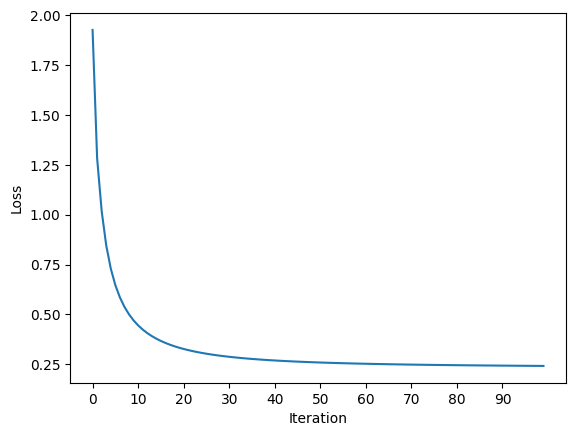

In [162]:
np.random.seed(SEED)

# Adjust the number of epochs and the learning rate
num_epochs = 100
learning_rate = 1.0

# Add a bias term
X_b = np.hstack([X_train, np.ones((X_train.shape[0], 1))])

# Number of samples
num_samples = X_b.shape[0]

# Random weights initialization
num_hidden_units = 10  # number of hidden units
W1 = np.random.normal(size=(X_b.shape[1], num_hidden_units))  # 2 features + 1 bias, 10 hidden units
W2 = np.random.normal(size=(num_hidden_units + 1, num_classes))  # 10 hidden units + 1 bias, 3 classes
h1 = np.ones((num_samples, num_hidden_units + 1))  # 10 hidden units + 1 bias

iteration = 0
loss_history = []
for epoch in range(num_epochs):
    # Forward pass (prediction)
    z1 = np.dot(X_b, W1)  # N x 10
    h1[:, :-1] = sigmoid(z1)  # N x 10
    z2 = np.dot(h1, W2)  # N x 3
    Y_pred = softmax(z2)  # N x 3

    # Loss
    loss_value = cross_entropy_loss(Y_pred, y_train)
    loss_history.append(loss_value)

    # Backward pass (gradient computation)
    grad_pred = cross_entropy_grad(Y_pred, y_train)
    grad_z2 = softmax_grad(grad_pred, Y_pred)
    grad_W2 = linear_gradW(grad_z2, h1)
    grad_h1 = linear_gradX(grad_z2, W2)
    grad_z1 = sigmoid_grad(grad_h1[:, :-1], h1[:, :-1])
    grad_W1 = linear_gradW(grad_z1, X_b)

    # Update weights
    W1 = W1 - learning_rate * grad_W1
    W2 = W2 - learning_rate * grad_W2

    iteration += 1
plot_loss_history(loss_history, interval=iteration//10)

### Test

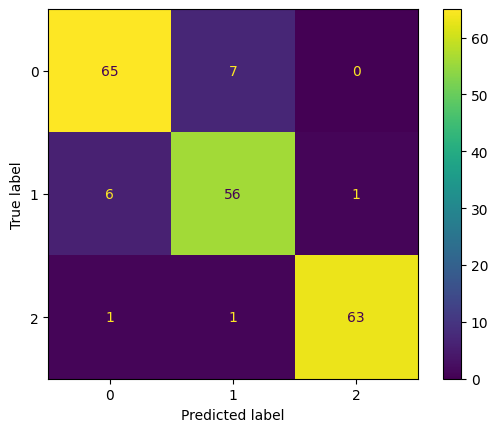


Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        72
           1       0.88      0.89      0.88        63
           2       0.98      0.97      0.98        65

    accuracy                           0.92       200
   macro avg       0.92      0.92      0.92       200
weighted avg       0.92      0.92      0.92       200



In [163]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

num_samples = X_test.shape[0]
X_b = np.hstack([X_test, np.ones((num_samples, 1))])
h1 = np.ones((num_samples, num_hidden_units + 1))  # 10 hidden units + 1 bias

# Forward pass (prediction)
z1 = np.dot(X_b, W1)  # N x 10
h1[:, :-1] = sigmoid(z1)  # N x 10
z2 = np.dot(h1, W2)  # N x 3
y_pred = np.argmax(z2, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Compute classification report
class_report = classification_report(y_test, y_pred)

print("\nClassification Report:")
print(class_report)